In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys

import datetime as dt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sk import LofarRaw 

%matplotlib inline

In [148]:
filename = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:45:00_19563123779296'
frange = [15,60]
sbs = np.arange(76,320)
obs_mode = 3
trange = TimeRange("2020-10-13T17:45:00", 15.*u.min)
xlabel = "Time from 2020/10/13 17:47:00.0000"
ylabel = "Frequency (MHz)"
title = filename.split('/')[1]

In [149]:
raw = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
flimits = np.array([40,94])
freqlimits = raw.sb_to_f(flimits+sbs[0], obs_mode)
xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
xlims = mdates.date2num(xlims)
raw.data = raw.data[:, flimits[0]:flimits[1]]

Time to read data: 0.000922s



In [150]:
raw.data.shape

(10986328, 54)

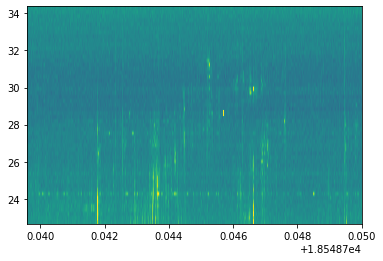

In [12]:
plt.figure()
im = plt.imshow(raw.data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(raw.data.T, 5), 
            vmax=np.nanpercentile(raw.data.T, 95),
            extent=[xlims[0], xlims[1], 
                    22.65625, 34.375])

In [8]:
from scipy.signal import stft, istft
import scipy.stats as st

In [14]:
_, _, stft_data = stft(raw.data, window='hamming', axis=0, nperseg=300.)

In [31]:
limit = raw.sk_threshold(0.99999, stft_data.shape[0])

In [32]:
print(limit)

0.7189289488541487


In [17]:
print(stft_data.shape)

(151, 54, 73244)


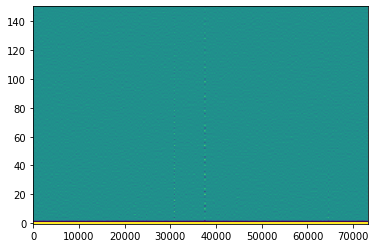

In [33]:
plt.figure()
im2 = plt.imshow(stft_data[:,0,:].real, aspect='auto', origin='lower', vmin=np.nanpercentile(stft_data.real, 5), vmax=np.nanpercentile(stft_data.real, 95))

In [54]:
np.quantile(stft_data.real, 0.5)

-0.00029641203582286835

In [39]:
stft_masked = np.ma.masked_outside(stft_data, v1=-100, v2=100, copy=False)

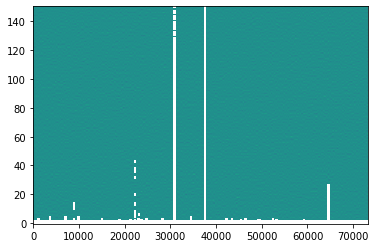

In [37]:
plt.figure()
im2 = plt.imshow(stft_masked.real, aspect='auto', origin='lower', vmin=np.nanpercentile(stft_masked.real, 5), vmax=np.nanpercentile(stft_masked.real, 95))

In [40]:
stft_masked.shape

(151, 54, 73244)

In [45]:
_, clean_data = istft(stft_masked, window='hamming', nperseg=300., freq_axis=0, time_axis=2)

In [57]:
type(clean_data)

numpy.ndarray

In [61]:
clean_data[:,1000000]

array([516.     , 573.00006, 642.     , 636.00006, 444.00003, 402.99994,
       590.     , 609.99994, 376.99997, 480.99994, 555.99994, 544.99994,
       542.     , 488.99997, 423.99994, 588.     , 587.     , 492.     ,
       395.99994, 466.00003, 510.     , 597.99994, 642.     , 350.     ,
       493.99994, 450.99994, 480.99994, 455.     , 585.99994, 516.     ,
       550.     , 500.00003, 496.99997, 458.     , 449.00006, 508.99997,
       581.00006, 528.     , 481.99994, 746.99994, 507.99997, 333.     ,
       595.99994, 626.     , 426.99994, 555.     , 716.9999 , 446.0001 ,
       620.99994, 633.99994, 517.99994, 433.99994, 406.     , 592.99994],
      dtype=float32)

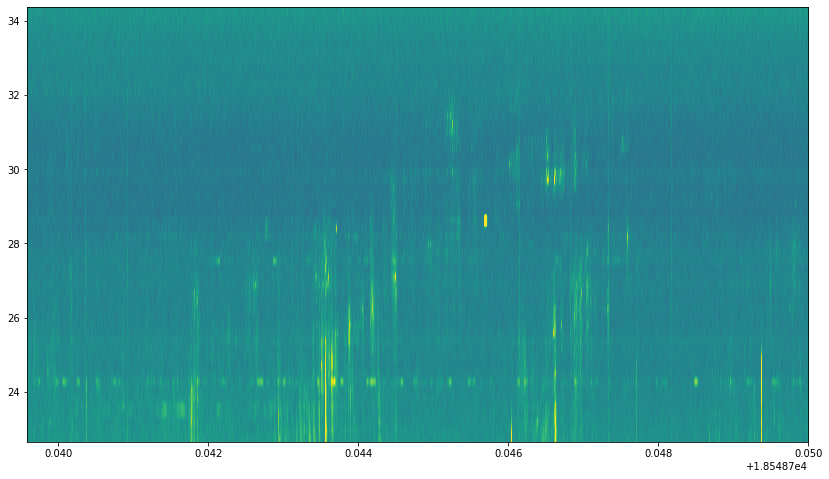

In [63]:
plt.figure(figsize=(14,8))
im = plt.imshow(clean_data, aspect='auto', origin='lower',
            vmin=np.nanpercentile(clean_data, 5), 
            vmax=np.nanpercentile(clean_data, 95),
            extent=[xlims[0], xlims[1], 
                    22.65625, 34.375])

In [66]:
raw.data.T.shape

(54, 10986328)

In [5]:
data = raw.data.T

In [6]:
data.shape

(54, 10986328)

In [9]:
Zxx_f, Zxx_t, Zxx = stft(data, window='hamming', axis=1, nperseg=256)

In [71]:
Zxx.shape

(54, 129, 85832)

In [11]:
sk = (np.mean((np.abs(Zxx)**4), axis=2)/np.mean((np.abs(Zxx)**2), axis=2)**2) - 2.

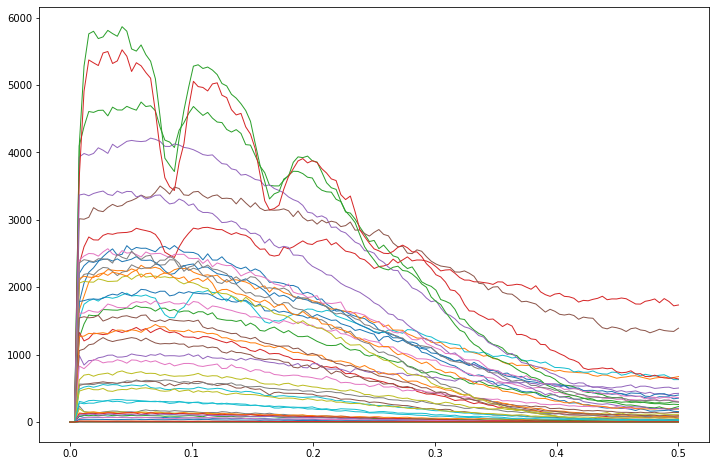

In [12]:
plt.figure(figsize=(12,8))
for i in range(54):
    plt.plot(Zxx_f, sk[i], lw=1)

In [35]:
for i,j in enumerate(sk):
    if j.max() > 2500:
        print(i, j.max())


0 2617.912
22 4748.5728
23 2888.9727
24 4212.8384
25 3501.866
32 5866.9077
33 5523.583
34 3427.2415
36 2571.3794
37 2535.9614


In [72]:
limit = st.norm.interval(0.95, scale=np.sqrt(4./Zxx.shape[1]))[1]

In [73]:
limit

0.3451304133107743

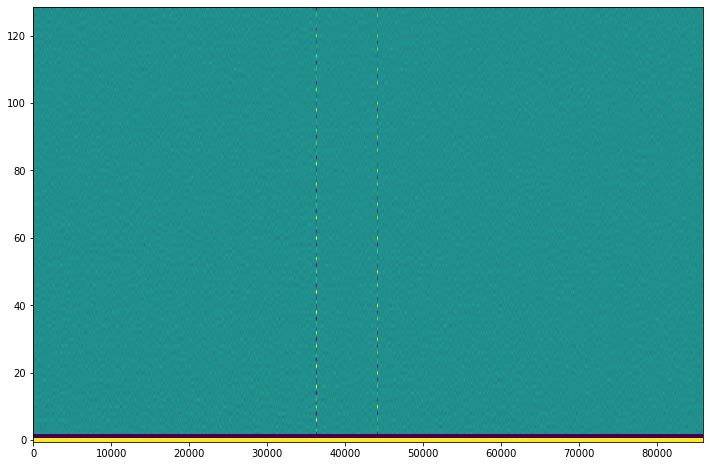

In [36]:
plt.figure(figsize=(12,8))
im = plt.imshow(Zxx[25].real, aspect='auto', origin='lower', vmin=np.nanpercentile(Zxx[25].real, 5), vmax=np.nanpercentile(Zxx[25].real, 95))
#im = plt.pcolormesh(Zxx_t, Zxx_f, np.abs(Zxx[25]))

In [74]:
mZxx = np.ma.masked_inside(Zxx, v1=-limit, v2=limit, copy=False)

In [75]:
mZxx.shape

(54, 129, 85832)

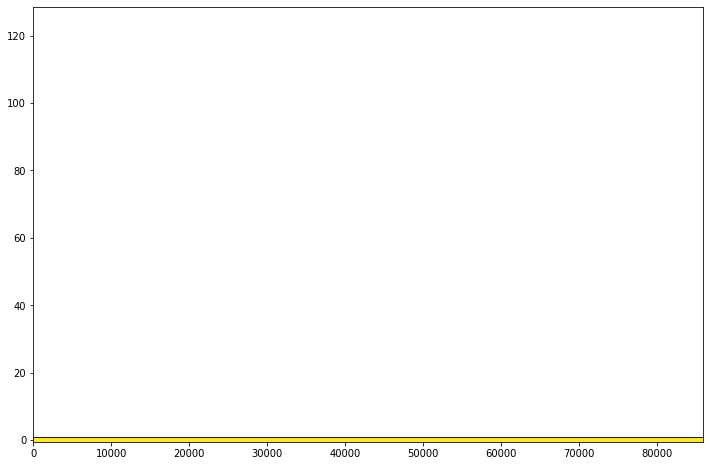

In [80]:
plt.figure(figsize=(12,8))
im = plt.imshow(mZxx[25].real, aspect='auto', origin='lower', vmin=np.nanpercentile(mZxx.real, 5), vmax=np.nanpercentile(mZxx.real, 95))

In [76]:
data_t, data_x = istft(mZxx, window='hamming', nperseg=256)

In [77]:
data_x.shape

(54, 10986368)

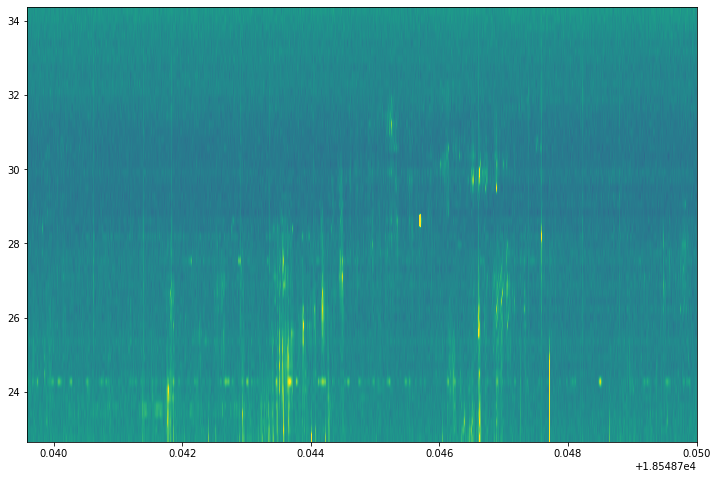

In [79]:
plt.figure(figsize=(12,8))
im = plt.imshow(data_x, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data_x, 5), 
            vmax=np.nanpercentile(data_x, 95),
            extent=[xlims[0], xlims[1], 
                    22.65625, 34.375])

In [49]:
mZxx = np.ma.masked_outside(Zxx, v1=-limit, v2=limit, copy=False)

In [50]:
mZxx.shape

(54, 129, 85832)

In [89]:
Zxx.shape

(54, 129, 85832)

In [91]:
zZxx = Zxx

In [97]:
limit = 10

In [98]:
zZxx[(zZxx > -limit) & (zZxx < 0)] = 0
zZxx[(zZxx < limit) & (zZxx > 0)] = 0

In [99]:
zZxx.shape

(54, 129, 85832)

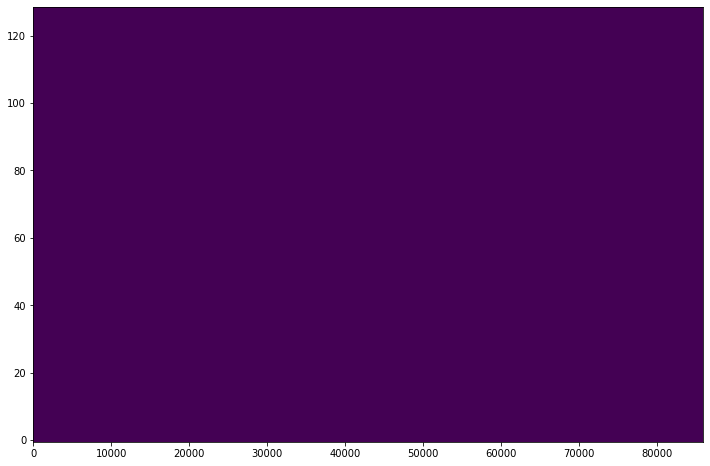

In [101]:
plt.figure(figsize=(12,8))
im = plt.imshow(zZxx[25].real, aspect='auto', origin='lower', vmin=np.nanpercentile(zZxx[25].real, 5), vmax=np.nanpercentile(zZxx[25].real, 95))

In [105]:
zxx_t, zxx_x = istft(zZxx, window='hamming', nperseg=256)

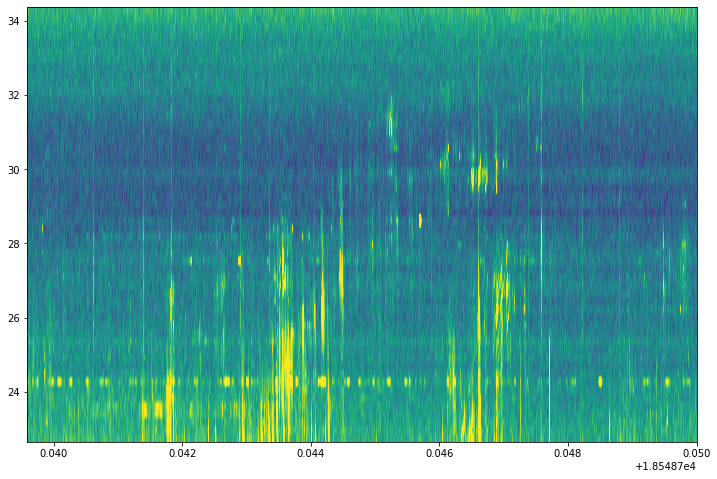

In [106]:
plt.figure(figsize=(12,8))
im = plt.imshow(zxx_x, aspect='auto', origin='lower',
            vmin=np.nanpercentile(zxx_x, 5), 
            vmax=np.nanpercentile(zxx_x, 95),
            extent=[xlims[0], xlims[1], 
                    22.65625, 34.375])

In [111]:
zxx_x.shape

(54, 10986368)

In [113]:
arrs = np.array_split(zxx_x, 6000, axis=1)

In [116]:
arrs[0].shape

(54, 1832)

In [129]:
for arr in arrs:
    norms = np.quantile(arr, 0.3, axis=1)
    arr = arr/norms[:,np.newaxis]

In [144]:
data = np.concatenate(np.array(arrs))

ValueError: could not broadcast input array from shape (54,1832) into shape (54)

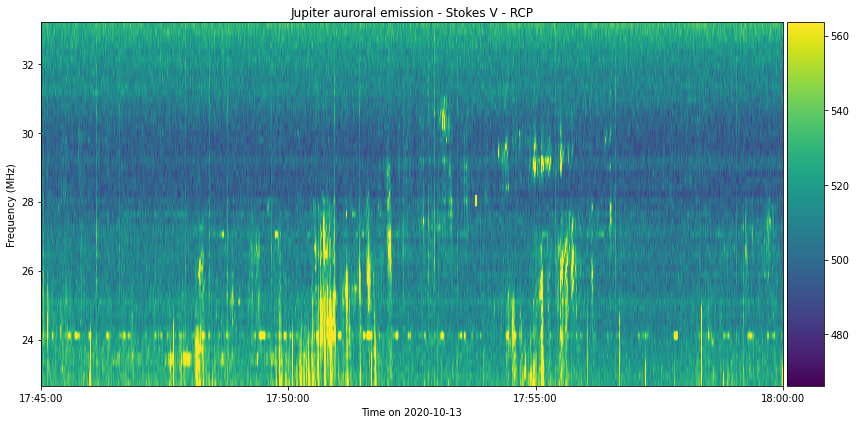

In [130]:
plt.figure(figsize=(12,6))
im = plt.imshow(zxx_x, aspect='auto', origin='lower',
            vmin=np.nanpercentile(zxx_x, 5), 
            vmax=np.nanpercentile(zxx_x, 95),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()
#plt.savefig('jupiter-stokesV-righthanded.png')

In [145]:
raw.data.shape

(10986328, 54)

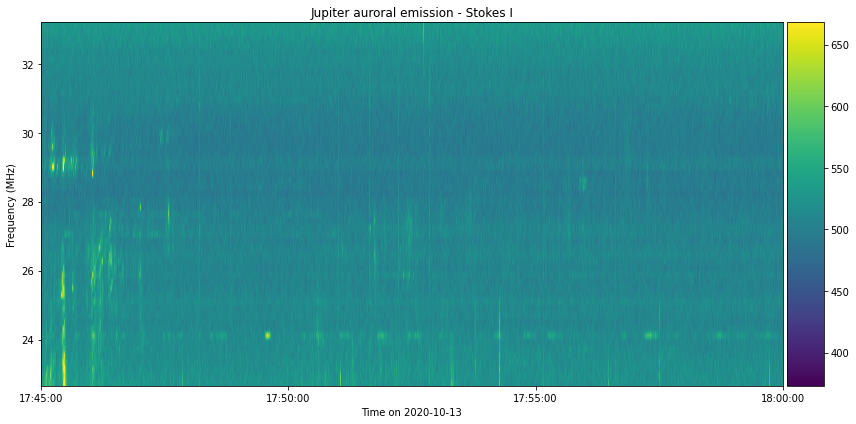

In [151]:
plt.figure(figsize=(12,6))
im = plt.imshow(raw.data.T[:,int(raw.data.shape[0]/2):-1], aspect='auto', origin='lower',
            vmin=np.nanpercentile(raw.data.T[:,int(raw.data.shape[0]/2):-1], 5), 
            vmax=np.nanpercentile(raw.data.T[:,int(raw.data.shape[0]/2):-1], 95),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

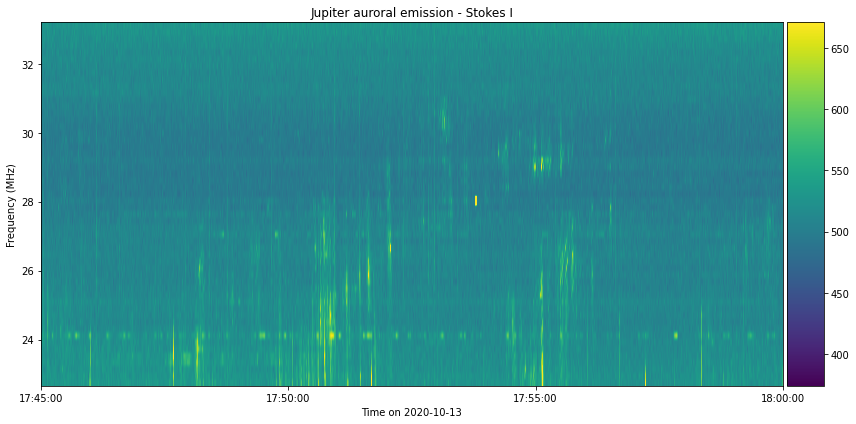

In [152]:
plt.figure(figsize=(12,6))
im = plt.imshow(raw.data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(raw.data.T, 5), 
            vmax=np.nanpercentile(raw.data.T, 95),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()